In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_generator = train_datagen.flow_from_directory(
    "dataset",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
    subset="training",
)

validation_generator = train_datagen.flow_from_directory(
    "dataset",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

print(train_generator.class_indices)

Found 9590 images belonging to 2 classes.
Found 2396 images belonging to 2 classes.
{'Fresh': 0, 'Rotten': 1}


In [17]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


model=keras.models.Sequential([
    # keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    # keras.layers.MaxPooling2D(2,2),
    # BatchNormalization(),
    # keras.layers.Conv2D(64,(3,3),activation='relu'),
    # keras.layers.MaxPooling2D(2,2),
    # BatchNormalization(),
    # keras.layers.Conv2D(128,(3,3),activation='relu'),
    # keras.layers.MaxPooling2D(2,2),
    # BatchNormalization(),
    # keras.layers.Conv2D(128,(3,3),activation='relu'),
    # keras.layers.MaxPooling2D(2,2),
    # BatchNormalization(),
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),  # Lower learning rate
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 22s 0us/step


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/15
106/299 [=========>....................] - ETA: 45s - loss: 0.6739 - accuracy: 0.5946

c:\Users\ariel\anaconda3\envs\py310\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


299/299 [==============================] - 100s 317ms/step - loss: 0.5984 - accuracy: 0.6695 - val_loss: 0.5023 - val_accuracy: 0.7715 - lr: 1.0000e-05
Epoch 2/15
299/299 [==============================] - 75s 250ms/step - loss: 0.4730 - accuracy: 0.7759 - val_loss: 0.4813 - val_accuracy: 0.7660 - lr: 1.0000e-05
Epoch 3/15
299/299 [==============================] - 75s 249ms/step - loss: 0.4355 - accuracy: 0.7967 - val_loss: 0.4352 - val_accuracy: 0.8036 - lr: 1.0000e-05
Epoch 4/15
299/299 [==============================] - 79s 263ms/step - loss: 0.4029 - accuracy: 0.8234 - val_loss: 0.4277 - val_accuracy: 0.8015 - lr: 1.0000e-05
Epoch 5/15
299/299 [==============================] - 75s 250ms/step - loss: 0.3867 - accuracy: 0.8299 - val_loss: 0.4111 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 6/15
299/299 [==============================] - 76s 252ms/step - loss: 0.3709 - accuracy: 0.8407 - val_loss: 0.4060 - val_accuracy: 0.8070 - lr: 1.0000e-05
Epoch 7/15
299/299 [==================

In [19]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

75/75 [==============================] - 19s 246ms/step - loss: 0.3880 - accuracy: 0.8201
Validation Accuracy: 82.01%


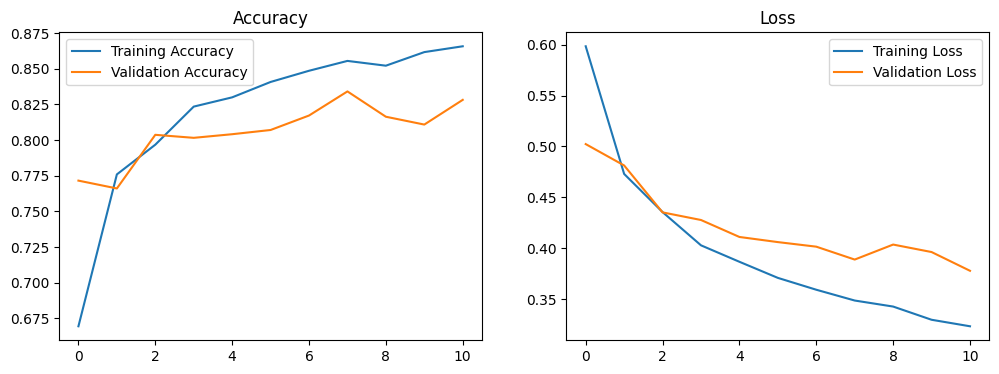

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

75/75 [==============================] - 15s 202ms/step


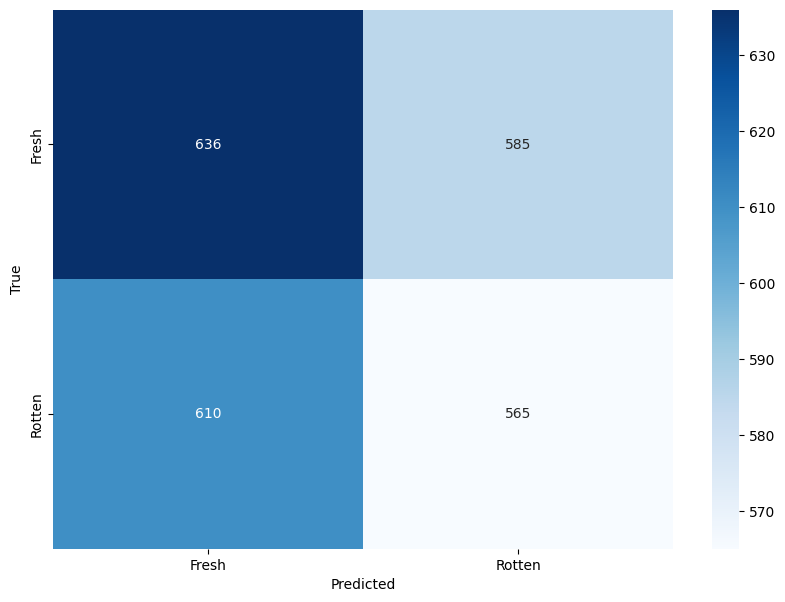

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = model.predict(validation_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Get true labels
y_true = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
model.save('models/freshness_model.h5')

In [9]:
test_image=keras.preprocessing.image.load_img('dataset/Rotten/RottenPotato/rottenPotato (4).jpg',target_size=(150,150))
test_image=keras.preprocessing.image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
print(result)
if result[0][0] > 0.5:
        print("Rotten")
else:
        print("Fresh")


1/1 [==============================] - 1s 544ms/step
[[1.]]
Rotten


In [11]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the path to the folder containing the images
folder_path = 'dataset/Fresh/FreshBanana'
image_files = os.listdir(folder_path)[:20]  # Get the first 20 images

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    
    # Load and preprocess the image
    test_image = load_img(image_path, target_size=(150, 150))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    
    # Make a prediction
    result = model.predict(test_image)
    
    # Print the result
    print(f"Image: {image_file}")
    if result[0][0] > 0.5:
        print("Rotten")
    else:
        print("Fresh")
    print(result)

1/1 [==============================] - 0s 18ms/step
Image: freshBanana (1).jpeg
Fresh
[[0.]]
1/1 [==============================] - 0s 18ms/step
Image: freshBanana (1).jpg
Fresh
[[0.]]
1/1 [==============================] - 0s 17ms/step
Image: freshBanana (1).png
Fresh
[[0.]]
1/1 [==============================] - 0s 16ms/step
Image: freshBanana (1).webp
Fresh
[[0.]]
1/1 [==============================] - 0s 19ms/step
Image: freshBanana (10).png
Fresh
[[0.]]
1/1 [==============================] - 0s 17ms/step
Image: freshBanana (100).jpg
Fresh
[[0.]]
1/1 [==============================] - 0s 22ms/step
Image: freshBanana (100).png
Fresh
[[0.]]
1/1 [==============================] - 0s 19ms/step
Image: freshBanana (101).jpg
Fresh
[[0.]]
1/1 [==============================] - 0s 18ms/step
Image: freshBanana (101).png
Fresh
[[0.]]
1/1 [==============================] - 0s 19ms/step
Image: freshBanana (102).jpg
Fresh
[[0.]]
1/1 [==============================] - 0s 17ms/step
Image: freshBan

In [23]:

from sklearn.metrics import accuracy_score

# Define the path to the folder containing the images
folder_path = 'dataset/Rotten/RottenApple'
image_files = os.listdir(folder_path)  # Get all images

# Initialize lists to store predictions and actual labels
predictions = []
actual_labels = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    
    # Load and preprocess the image
    test_image = load_img(image_path, target_size=(150, 150))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    
    # Make a prediction
    result = model.predict(test_image)
    
    # Append the prediction (1 for Rotten, 0 for Fresh)
    predictions.append(1 if result[0][0] > 0.5 else 0)
    
    # Append the actual label (assuming all images in the folder are Fresh)
    actual_labels.append(0)

# Calculate the accuracy score
accuracy = accuracy_score(actual_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 19ms/step
Accuracy: 17.18%


In [1]:
import os

def count_images_in_directory(directory_path):
    count = 0
    for root, dirs, files in os.walk(directory_path):
        count += len([file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'webp'))])
    return count

fresh_directory = 'dataset/Fresh'
rotten_directory = 'dataset/Rotten'

num_fresh_images = count_images_in_directory(fresh_directory)
num_rotten_images = count_images_in_directory(rotten_directory)

print(f"Number of Fresh images: {num_fresh_images}")
print(f"Number of Rotten images: {num_rotten_images}")

Number of Fresh images: 6098
Number of Rotten images: 5855
